#1. Librerías

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm
import time
import copy

In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T # for simplifying the transforms
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models

In [ ]:
!pip install timm # kaggle doesnt have it installed by default
import timm
from timm.loss import LabelSmoothingCrossEntropy

#2. Funciones

In [ ]:
def get_classes(data_dir):
    all_data = datasets.ImageFolder(data_dir)
    return all_data.classes

In [ ]:
def get_data_loaders(data_dir, batch_size, train = False):
    if train:
        #train
        transform = T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter()]), p=0.25),
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
            T.RandomErasing(p=0.2, value='random')
        ])
        train_data = datasets.ImageFolder(os.path.join(data_dir, "train/"), transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, len(train_data)
    else:
        # val/test
        transform = T.Compose([ # We dont need augmentation for test transforms
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # imagenet means
        ])
        val_data = datasets.ImageFolder(os.path.join(data_dir, "val/"), transform=transform)
        test_data = datasets.ImageFolder(os.path.join(data_dir, "test/"), transform=transform)
        prueba_data = datasets.ImageFolder("/gdrive/MyDrive/Proyecto/Copia_dataset/prueba", transform=transform)
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        prueba_loader = DataLoader(prueba_data, shuffle=True, num_workers=4)
        return val_loader, test_loader, len(val_data), len(test_data), prueba_loader, len(prueba_data)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=1):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print("-"*10)

        for phase in ['train', 'val']: # We do training and validation phase per epoch
            if phase == 'train':
                model.train() # model to training mode
            else:
                model.eval() # model to evaluate

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'): # no autograd makes validation go faster
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # used for accuracy
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step() # step at end of epoch

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc =  running_corrects.double() / dataset_sizes[phase]

            print("{} Loss: {:.4f} Acc: {:.4f}".format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) #jj keep the best validation accuracy model
        print()
    time_elapsed = time.time() - since # slight error
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val Acc: {:.4f}".format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def num2label(num):
  if num == 0:
    return 'MildDemented'
  elif num == 1:
    return 'ModerateDemented'
  elif num == 2:
    return 'NonDemented'
  elif num == 3:
    return 'VeryMildDemented'
  else:
    return 'Class Does Not Exist'

#3. Acceso al Dataset.

In [ ]:
data_path = "/gdrive/MyDrive/Proyecto/Copia_dataset"

In [ ]:
(train_loader, train_data_len) = get_data_loaders(data_path, 128, train=True)
(val_loader, test_loader, valid_data_len, test_data_len, prueba_loader, prueba_data_len) = get_data_loaders(data_path, 32, train=False)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
classes = get_classes("/gdrive/MyDrive/Proyecto/Copia_dataset/train")
print(classes, len(classes))

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'] 4


In [ ]:
dataloaders = {
    "train": train_loader,
    "val": val_loader,
    "test": test_loader
}
dataset_sizes = {
    "train": train_data_len,
    "val": valid_data_len,
    "test": test_data_len
}

In [ ]:
print("Número de Batches para entrenamiento: "+str(len(train_loader))+", Número de Batches para Validación: "+str(len(val_loader)))
print("Número de imágenes para entrenamiento: "+str(train_data_len)+", Número de imágenes para Validación: "+str(valid_data_len))

Número de Batches para entrenamiento: 267, Número de Batches para Validación: 192
Número de imágenes para entrenamiento: 34153, Número de imágenes para Validación: 6125


#4. Modelo

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
#como contenedor usamos un modelo predefinido y preentrenado
model = torch.hub.load('facebookresearch/deit:main', 'deit_tiny_patch16_224', pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

n_inputs = model.head.in_features
model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(classes))
)
model = model.to(device)
print(model.head)

Sequential(
  (0): Linear(in_features=192, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=4, bias=True)
)


In [ ]:
criterion = LabelSmoothingCrossEntropy() #Método regularizador escogido
criterion = criterion.to(device)
optimizer = optim.Adam(model.head.parameters(), lr=0.001) #Utilizaremos Adam

In [ ]:
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

#5. Entrenamiento

In [ ]:
model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler)

#6. Carga y Descarga de modelos entrenados en distintas épocas

In [ ]:
#Este método guarda un archivo de extensión .pt que almacena el módelo entrenado.
torch.save(model_ft, "modeloA1epoch.pt")

In [ ]:
#modelo_entrenado = torch.load("/content/modeloA1epoch.pt",map_location=torch.device('cpu'))  #Modelo entrenado con 1 época.
modelo_entrenado = torch.load("/content/modeloA10epoch.pt",map_location=torch.device('cpu')) #Modelo entrenado con 10 épocas.
#modelo_entrenado = torch.load("/content/modeloA20epoch.pt",map_location=torch.device('cpu')) #Modelo entrenado con 20 épocas.

#7. Testeo

In [ ]:
test_loss = 0.0
class_correct = list(0 for i in range(len(classes)))
class_total = list(0 for i in range(len(classes)))
modelo_entrenado.eval()

for data, target in tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    with torch.no_grad(): # turn off autograd for faster testing
        output = modelo_entrenado(data)
        loss = criterion(output, target)
    test_loss = loss.item() * data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    if len(target) == 32:
        for i in range(32):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

test_loss = test_loss / test_data_len
print('Test Loss: {:.4f}'.format(test_loss))
for i in range(len(classes)):
    if class_total[i] > 0:
        print("Test Accuracy of %5s: %2d%% (%2d/%2d)" % (
            classes[i], 100*class_correct[i]/class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])
        ))
    else:
        print("Test accuracy of %5s: NA" % (classes[i]))
print("Test Accuracy of %2d%% (%2d/%2d)" % (
            100*np.sum(class_correct)/np.sum(class_total), np.sum(class_correct), np.sum(class_total)
        ))

100%|██████████| 11/11 [00:46<00:00,  4.21s/it]

Test Loss: 0.0809
Test Accuracy of MildDemented: 88% (75/85)
Test Accuracy of ModerateDemented: 93% (54/58)
Test Accuracy of NonDemented: 63% (59/93)
Test Accuracy of VeryMildDemented: 34% (29/84)
Test Accuracy of 67% (217/320)


#8. Prueba

--------Label--------
ModerateDemented
-------Predicciones-----
ModerateDemented


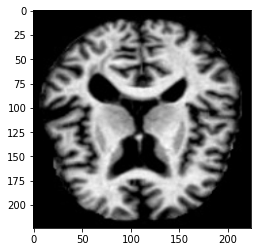

In [ ]:
i=0
#modelo_entrenado = torch.load("/modeloA10epoch.pt",map_location=torch.device('cpu'))
for input, label in prueba_loader:
  plt.imshow(input[0][0], cmap = "gray")
  print("--------Label--------")
  print(num2label(label))
  outputs = modelo_entrenado(input)
  _, preds = torch.max(outputs, 1) # used for accuracy
  print("-------Predicciones-----")
  print(num2label(preds))
  i +=1
  if i>0:
    break
